In [4]:
# Import necessary libraries
import numpy as np
import torch
from torch.nn import Tanh
from stable_baselines3 import PPO
from dm_control import suite
import gymnasium as gym
from gymnasium import spaces
import hashlib
import os
from concurrent.futures import ThreadPoolExecutor
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json

In [5]:
# Мир, в котором живёт гепард и учится бегать.
class DMControlWrapper(gym.Env):
    def __init__(self, domain_name, task_name):
        self.env = suite.load(domain_name=domain_name, task_name=task_name)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=self.env.action_spec().shape, dtype=np.float32)
        
        # Assume all observations are concatenated into a single vector
        obs_spec = self.env.observation_spec()
        obs_dim = sum(np.prod(spec.shape) for spec in obs_spec.values())
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

    def step(self, action):
        time_step = self.env.step(action)
        reward = time_step.reward if time_step.reward is not None else 0
        terminated = time_step.last()
        truncated = False  # Set to True if you have a specific truncation condition
        
        # Concatenate all observations into a single vector
        obs = self._flatten_observation(time_step.observation)
        return obs, reward, terminated, truncated, {}

    def reset(self, seed=None, **kwargs):
        if seed is not None:
            np.random.seed(seed)
            self.env.task.random.seed(seed)
        time_step = self.env.reset()
        obs = self._flatten_observation(time_step.observation)
        return obs, {}  # Return observation and empty info dict

    def render(self, mode='human'):
        return self.env.physics.render()

    def _flatten_observation(self, observation):
        # Flatten the observation dictionary into a single numpy array
        return np.concatenate([np.array(value).flatten() for value in observation.values()])

# Usage
env = DMControlWrapper('cheetah', 'run')

In [6]:
# Мозг, который придумывает, как может выглядеть нейросеть.
class Controller(nn.Module): 
    def __init__(self, input_size, hidden_size, num_layers):
        super(Controller, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc_layers = nn.Linear(hidden_size, 5)  # Predefined options: 1, 2, or 3 layers
        self.fc_units = nn.Linear(hidden_size, 3)  # Predefined options: 64, 128, or 256 units
        self.fc_activation = nn.Linear(hidden_size, 3)  # Predefined options: ReLU or Tanh
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out_layers = self.fc_layers(out)
        out_units = self.fc_units(out)
        out_activation = self.fc_activation(out)
        return out_layers, out_units, out_activation, hidden

    def init_hidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size),
                torch.zeros(self.num_layers, 1, self.hidden_size))

    def sample_architecture(self, temperature=1.2, epsilon=0.1):
        """
        Generate a valid architecture for Stable-Baselines3.
        Returns a list of dictionaries specifying shared and policy/value networks.
        """
        if random.random() < epsilon:
            # 👉 Генерируем случайную архитектуру вместо контроллера
            num_layers = random.choice([1, 2, 3, 4, 5])
            units = random.choice([64, 128, 256])
            activation_func = random.choice(['relu', 'leaky_relu', 'swish'])

            pi = [units] * num_layers
            vf = [units] * num_layers

            architecture = dict(pi=pi, vf=vf, activation=activation_func)

            # Вернём dummy значения для log_prob и entropy (они не нужны — случайная архитектура)
            return architecture, torch.tensor(0.0), torch.tensor(0.0)

        hidden = self.init_hidden()
        x = torch.zeros(1, 1, 10)  # Dummy input
        
        out_layers, out_units, out_activation, _ = self.forward(x, hidden)
        
        layers_logits = out_layers.squeeze() / temperature
        units_logits = out_units.squeeze() / temperature
        activation_logits = out_activation.squeeze() / temperature
        
        # Sample from the outputs
        layers_probs = torch.softmax(out_layers.squeeze(), dim=0)
        units_probs = torch.softmax(out_units.squeeze(), dim=0)
        activation_probs = torch.softmax(out_activation.squeeze(), dim=0)
        
        # Энтропия для регуляризации
        entropy_layers = - (layers_probs * torch.log(layers_probs + 1e-8)).sum()
        entropy_units = - (units_probs * torch.log(units_probs + 1e-8)).sum()
        entropy_activation = - (activation_probs * torch.log(activation_probs + 1e-8)).sum()
        total_entropy = entropy_layers + entropy_units + entropy_activation

        # layers_idx = torch.multinomial(layers_probs, 1).item()
        units_idx = torch.multinomial(units_probs, 1).item()
        activation_idx = torch.multinomial(activation_probs, 1).item()
        
        # Convert indices to actual values
        layers_idx = torch.multinomial(layers_probs, 1).item()
        num_layers = random.randint(1, 5)  # 1, 2, or 3 layers
        # units = [64, 128, 256][units_idx]  # 64, 128, or 256 units
        activation_func = ['relu', 'leaky_relu', 'swish'][activation_idx]  # Select activation function

        # Save log_probs for later loss calculation
        log_prob_layers = torch.log(layers_probs[layers_idx])
        log_prob_units = torch.log(units_probs[units_idx])
        log_prob_activation = torch.log(activation_probs[activation_idx])

        # Собираем логарифмы вероятностей в один тензор
        log_prob_sum = log_prob_layers + log_prob_units + log_prob_activation

        # Формируем архитектуру
        num_layers = layers_idx + 1  # если 0-based индекс для 1..3 слоев
        units_options = [64, 128, 256]
        units = units_options[units_idx]
        activations = ['relu', 'leaky_relu', 'swish']
        activation_func = activations[activation_idx]

        pi = [units] * num_layers
        vf = [units] * num_layers
            
        # Format: [dict(pi=[...], vf=[...])]
        architecture = dict(
            pi=pi,  # Policy network
            vf=vf,  # Value network
            activation=activation_func  # Функция активации
        )
        
        return architecture, log_prob_sum, total_entropy

In [7]:
def get_activation_function(name):
    if name == 'relu':
        return nn.ReLU  # ✅ no parentheses!
    elif name == 'leaky_relu':
        return nn.LeakyReLU
    elif name == 'swish':
        return nn.SiLU  # Swish = SiLU
    else:
        raise ValueError(f"Unknown activation function: {name}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# Обучает гепарда с архитектурой, которую придумал мозг.
def train_agent(env, architecture, total_timesteps=5000):
    """
    Trains a PPO agent with the given architecture on the provided environment.
    
    :param env: The gym environment.
    :param architecture: A dictionary defining the neural network architecture.
    :param total_timesteps: Total timesteps to train the agent.
    :return: Trained PPO agent.
    """
    # Wrap the environment in a DummyVecEnv
    vec_env = DummyVecEnv([lambda: env])
    
    # Define the policy_kwargs with the architecture
    pi_layers = architecture['pi']
    vf_layers = architecture['vf']
    activation = architecture['activation']

    # Build proper policy_kwargs
    policy_kwargs = dict(
        net_arch=[dict(pi=pi_layers, vf=vf_layers)],
        activation_fn=get_activation_function(activation)
    )
    
    print("Training with architecture:", architecture)

    # Обучаем
    model = PPO("MlpPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1)
    model.learn(total_timesteps=total_timesteps)    
    return model

def evaluate_agent(model, env, n_episodes=5):
    """
    Evaluate a trained RL agent.
    
    :param model: Trained PPO model
    :param env: Gym environment (must be unwrapped or DummyVecEnv)
    :param n_episodes: Number of episodes to run
    :return: Average reward per episode
    """
    total_rewards = []

    for episode in range(n_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_reward += reward[0] if isinstance(reward, (list, np.ndarray)) else reward
        
        total_rewards.append(episode_reward)

    average_reward = sum(total_rewards) / n_episodes
    print(f"Average reward over {n_episodes} episodes: {average_reward}")
    return average_reward
    
# Цикл: мозг придумывает → гепард учится → мы смотрим, как он бегает.
def run_nas(controller, env, episodes):
    optimizer = optim.Adam(controller.parameters(), lr=0.001) # used for Controller update based on reward

    last_arch_str = None
    same_count = 0
    best_reward = -float('inf')  # Начальная минимальная награда
    top_architectures = []
    rewards_list = []
    losses_list = []

    for episode in range(episodes):
        architecture, log_prob, entropy = controller.sample_architecture()
        arch_str = json.dumps(architecture, sort_keys=True)

        print(f"Testing architecture: {architecture}")
        
        if arch_str == last_arch_str:
            same_count += 1
        else:
            same_count = 1
            last_arch_str = arch_str

        agent = train_agent(env, architecture)
        
        # Evaluate the agent
        vec_env = DummyVecEnv([lambda: env])
        obs = vec_env.reset()
        total_reward = 0
        done = False

        while not done:
            action, _ = agent.predict(obs, deterministic=True)
            obs, rewards, dones, infos = vec_env.step(action)
            total_reward += rewards[0]
            done = dones[0]
        print(f"Episode {episode} Total Reward: {total_reward}")
        
        if same_count >= 5:
            print(f"⚠️ Architecture repeated {same_count} times. Penalizing reward.")
            total_reward *= 0.5 

        entropy_coef = 0.05  # настрой по ощущениям
        loss = -log_prob * total_reward - entropy_coef * entropy
        
        if log_prob.requires_grad:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            print("🟡 Skipped optimizer step (random architecture)")

        print(f"Episode {episode} Loss: {loss.item()} Reward: {total_reward}")
        rewards_list.append(total_reward)
        losses_list.append(loss.item())
        top_architectures.append((architecture, total_reward))

        # Optionally, save the best controller state during each episode if needed
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(controller.state_dict(), 'controller_best.pth')
            print(f"New best architecture found: {architecture} with reward: {total_reward}")

        # Отрисовка графиков
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rewards_list, label='Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward during NAS')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(losses_list, label='Controller Loss', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Controller Loss during NAS')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # Sort the architectures based on reward (descending order)
    top_architectures.sort(key=lambda x: x[1], reverse=True)

    # Get the top 7 architectures
    top_architectures = top_architectures[:5]
    print(f"Top architectures: {top_architectures}")
    return top_architectures


Controller state loaded from 'controller_best.pth'
Testing architecture: {'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}
Training with architecture: {'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}
Using cpu device


/Users/sofiabalaba/miniforge3/envs/autorl/lib/python3.10/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 5570 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3662        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017006854 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.5        |
|    explained_variance   | -9.78       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0421     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0303     |
|    std                  | 0.997       |
|    value_loss           | 0.0277      |
----------------------------------

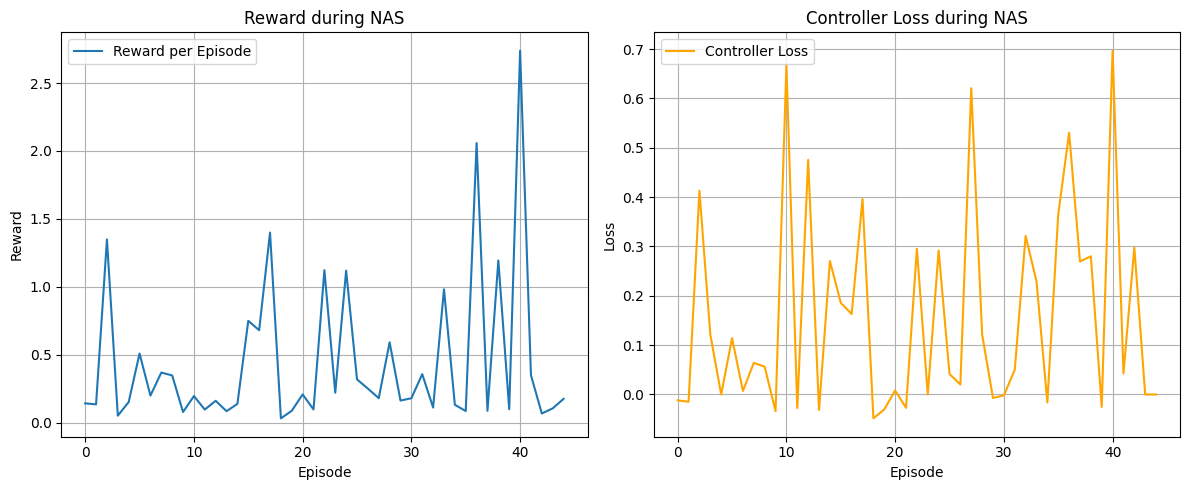

Top architectures: [({'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}, np.float32(2.7375891)), ({'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}, np.float32(2.058169)), ({'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}, np.float32(1.399769)), ({'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}, np.float32(1.3492789)), ({'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}, np.float32(1.1945989))]


In [8]:
# Example usage
env = DMControlWrapper('cheetah', 'run')
controller = Controller(input_size=10, hidden_size=32, num_layers=1)
if os.path.exists('controller_best.pth'):
    controller.load_state_dict(torch.load('controller_best.pth'))
    print(f"Controller state loaded from 'controller_best.pth'")
else:
    print(f"No saved controller state found at 'controller_best.pth'")
top_architectures = run_nas(controller, env, 45)

In [9]:
# Initialize variables to track the best architecture
best_reward = -float('inf')
best_architecture = None

# Iterate over the top architectures and evaluate each one
for i, (architecture, reward) in enumerate(top_architectures):
    print(f"Evaluating architecture {i + 1}: {architecture}")
    
    rewards = []
    for _ in range(3):
        model = train_agent(env, architecture, 30000)
        r = evaluate_agent(model, DummyVecEnv([lambda: env]), n_episodes=3)
        rewards.append(r)
    
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(f"Architecture {i + 1} average reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Используй avg_reward для сравнения архитектур
    if avg_reward > best_reward:
        best_reward = avg_reward
        best_architecture = architecture
        print(f"New best architecture found: {best_architecture} with avg reward: {best_reward:.2f}")

Evaluating architecture 1: {'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}
Training with architecture: {'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5563 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 3676       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01767364 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.54      |
|    explained_variance   | -3.42      |
|    learning_rate        | 0.0003     |
|    loss                 |

In [10]:
set_seed(42)
best_model = train_agent(env, best_architecture, total_timesteps=100000)

Training with architecture: {'pi': [128, 128, 128, 128], 'vf': [128, 128, 128, 128], 'activation': 'relu'}
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5636 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3684        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018100817 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.52       |
|    explained_variance   | -8.24       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.058      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0323 

In [11]:
baseline_architecture = {
    'pi': [64, 64],
    'vf': [64, 64],
    'activation': 'relu'
}

set_seed(42)
test_model_base = train_agent(env, baseline_architecture, total_timesteps = 100000)

Training with architecture: {'pi': [64, 64], 'vf': [64, 64], 'activation': 'relu'}
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 7196 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5074        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009518148 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.52       |
|    explained_variance   | -9.77       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00972     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0186     |
|    std          

In [12]:
set_seed(42)
evaluate_agent(best_model, DummyVecEnv([lambda: env]), n_episodes=100)

Average reward over 100 episodes: 94.70902252197266


np.float32(94.70902)

In [13]:
set_seed(42)
evaluate_agent(test_model_base, DummyVecEnv([lambda: env]), n_episodes=100)

Average reward over 100 episodes: 41.181827545166016


np.float32(41.181828)